The goal of this project is to build a reliable time-series regression model capable of forecasting daily sales for each store and product family within the Corporación Favorita dataset.

Precise sales forecasting plays a vital role in retail decision-making, supporting effective inventory management, promotional planning, and overall supply chain efficiency. This problem is treated as a supervised learning task, where historical sales data along with relevant external variables are leveraged to estimate future demand patterns.

The model’s performance is assessed using Root Mean Squared Logarithmic Error (RMSLE), a metric that emphasizes relative differences in predictions while reducing the impact of scale variations across different stores and product categories.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_log_error
from lightgbm import LGBMRegressor


In [2]:
train_df = pd.read_csv("/kaggle/input/store-sales-time-series-forecasting/train.csv")
test_df = pd.read_csv("/kaggle/input/store-sales-time-series-forecasting/test.csv")
sample_df = pd.read_csv("/kaggle/input/store-sales-time-series-forecasting/sample_submission.csv")

stores_df = pd.read_csv("/kaggle/input/store-sales-time-series-forecasting/stores.csv")
oil_df = pd.read_csv("/kaggle/input/store-sales-time-series-forecasting/oil.csv")
holidays_df = pd.read_csv("/kaggle/input/store-sales-time-series-forecasting/holidays_events.csv")
transactions_df = pd.read_csv("/kaggle/input/store-sales-time-series-forecasting/transactions.csv")

In [3]:
train_df.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [4]:
train_df.describe()

,id,store_nbr,sales,onpromotion
count,3.000888e+06,3.000888e+06,3.000888e+06,3.000888e+06
mean,1.500444e+06,2.750000e+01,3.577757e+02,2.602770e+00
std,8.662819e+05,1.558579e+01,1.101998e+03,1.221888e+01
min,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
25%,7.502218e+05,1.400000e+01,0.000000e+00,0.000000e+00
50%,1.500444e+06,2.750000e+01,1.100000e+01,0.000000e+00
75%,2.250665e+06,4.100000e+01,1.958473e+02,0.000000e+00
max,3.000887e+06,5.400000e+01,1.247170e+05,7.410000e+02


In [5]:
train_df.isna().sum().sort_values(ascending=False).head(15)

id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64

In [6]:
train_df["date"] = pd.to_datetime(train_df["date"])
test_df["date"] = pd.to_datetime(test_df["date"])
oil_df["date"] = pd.to_datetime(oil_df["date"])
holidays_df["date"] = pd.to_datetime(holidays_df["date"])
transactions_df["date"] = pd.to_datetime(transactions_df["date"])

In [7]:
train_df.sample(5)

,id,date,store_nbr,family,sales,onpromotion
1692515,1692515,2015-08-10,48,FROZEN FOODS,266.690,3
2388478,2388478,2016-09-05,26,BOOKS,0.000,0
2952109,2952109,2017-07-19,4,POULTRY,365.263,0
2971534,2971534,2017-07-30,35,HOME AND KITCHEN II,71.000,0
2334911,2334911,2016-08-06,22,PREPARED FOODS,38.000,1


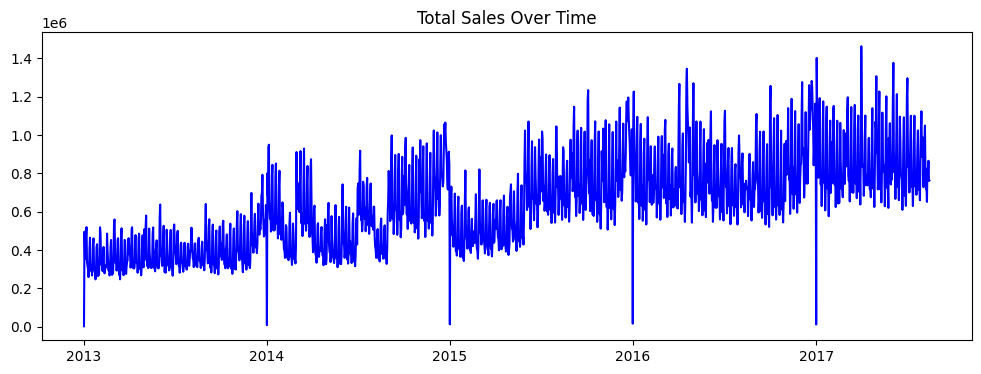

In [8]:
tmp = train_df.groupby("date", as_index=False)["sales"].sum()
plt.figure(figsize=(12,4))
plt.plot(tmp["date"], tmp["sales"], color="blue")
plt.title("Total Sales Over Time")
plt.show()

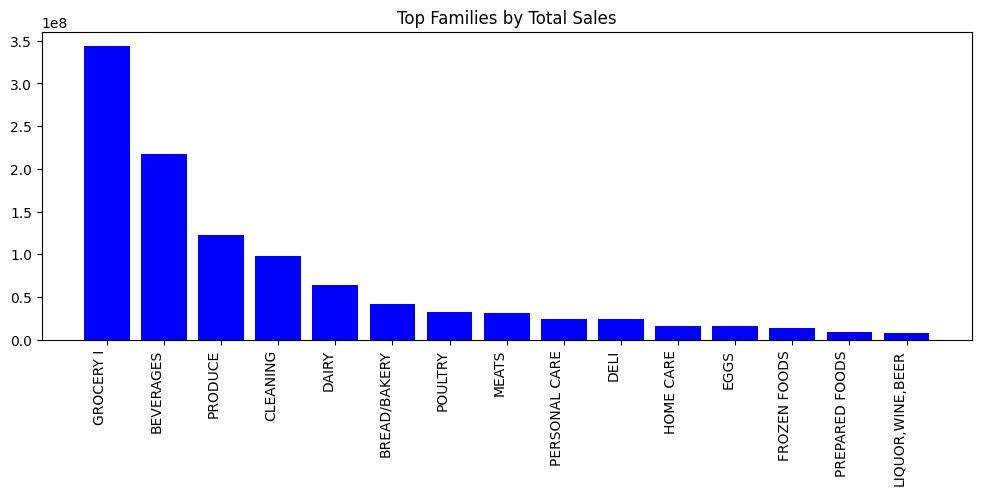

In [9]:
tmp2 = train_df.groupby("family", as_index=False)["sales"].sum().sort_values("sales", ascending=False).head(15)
plt.figure(figsize=(12,4))
plt.bar(tmp2["family"], tmp2["sales"], color="blue")
plt.xticks(rotation=90, ha="right")
plt.title("Top Families by Total Sales")
plt.show()

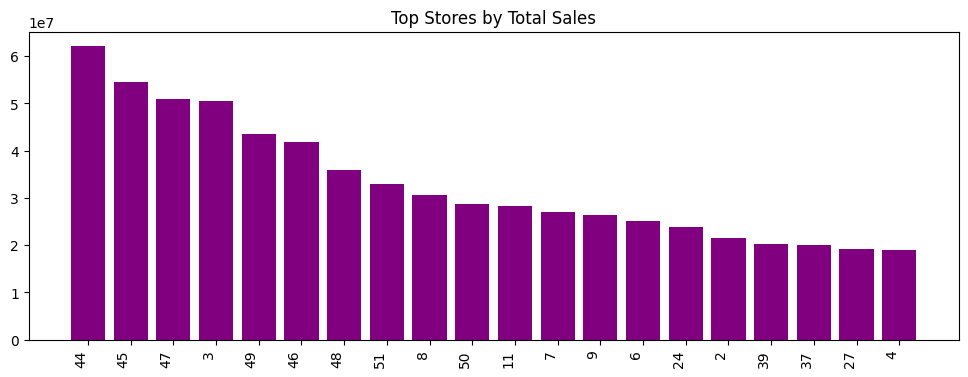

In [10]:
tmp3 = train_df.groupby("store_nbr", as_index=False)["sales"].sum().sort_values("sales", ascending=False).head(20)
plt.figure(figsize=(12,4))
plt.bar(tmp3["store_nbr"].astype(str), tmp3["sales"], color="purple")
plt.xticks(rotation=90, ha="right")
plt.title("Top Stores by Total Sales")
plt.show()

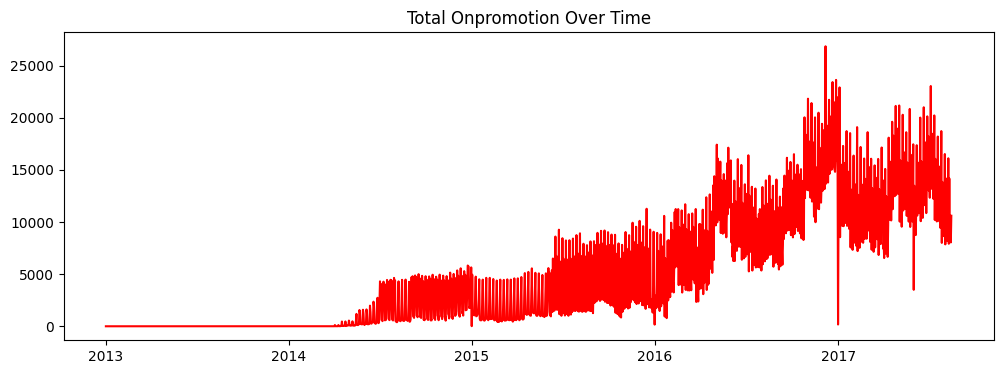

In [11]:
tmp4 = train_df.groupby("date", as_index=False)["onpromotion"].sum()
plt.figure(figsize=(12,4))
plt.plot(tmp4["date"], tmp4["onpromotion"], color="red")
plt.title("Total Onpromotion Over Time")
plt.show()